# CNN Neuron Clustering

In this notebook, we characterize the neurons in the CNN layers of CLAP on the basis of their activation vector: a 2000-dimensional vector, where each dimension's value
corresponds to the given neuron's activation for the dataset example referred to by that index.

## Index

- [Initialization](#initialization)
- [Embeddings for neurons](#embeddings-for-neurons)

## Initialization

This section contains necessary setup for the experiment. It can usually be collapsed and the experiment can still be understood without poring over these details.

- [Imports and hyperparameters](#imports-and-hyperparameters)
- [Seeding randomness](#seeding-randomness)
- [Loading the model and dataset](#loading-the-model-and-dataset)

In [2]:
from CLAPWrapper import CLAPWrapper
from esc50_dataset import ESC50
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
import os
import re
import logging
from collections import Counter
from datetime import datetime
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm
from icecream import ic
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.cluster import HDBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from IPython.display import Audio, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from typing import Callable, List
from finch import FINCH
from hnne import HNNE

The `module_activation_dict`'s keys are precisely the layers of interest, the activations for which are stored.
The activation functions are needed for our method of activation storage.

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_K = 100
NUM_CLASSES = 50
NUM_INSTANCES = 2000

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),
    'audio_encoder.base.conv_block2': nn.Identity(),
    'audio_encoder.base.conv_block3': nn.Identity(),
    'audio_encoder.base.conv_block4': nn.Identity(),
    'audio_encoder.base.conv_block5': nn.Identity(),
    'audio_encoder.base.conv_block6': nn.Identity(),
}

module_list = list(module_activation_dict.keys())

### Seeding randomness
This is to seed any and all randomness that might be present in the model.  \
This **should** only be the dropout layers in between the projection matrices, and a random sample
of the audio to be taken if the model's input audio duration, does **not** match with
the dataset's input audio duration.

The dropout layers should be deactivated after turning the model to evaluation mode, and
CLAP 's expected audio duration does match with ESC-50's audio duration (5 seconds), so this shouldn't matter,
but better to be safe than sorry.


In [5]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
seed_everything(42)

### Loading the model and dataset


#### Loading weights
Microsoft has made the pre-trained weights for CLAP available for download on request [here](https://zenodo.org/record/7312125#.Y22vecvMIQ9).

In [7]:
weights_path = "/scratch/pratyaksh.g/clap/CLAP_weights_2022_microsoft.pth"
clap_model = CLAPWrapper(weights_path, use_cuda=True if DEVICE == "cuda" else False)

In [8]:
clap_model.clap.eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

#### Loading dataset
We use the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50), which consists of 2000 recordings across 50 classes of environmental sounds, each 5 seconds long.

In [9]:
dataset = ESC50(root="/scratch/pratyaksh.g/esc50/", download=False)

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


928it [00:00, 9278.95it/s]

Loading audio files


2000it [00:00, 9351.60it/s]


## Embeddings for neurons

As mentioned earlier, the embedding for a neuron is simply the vector whose elements are that neuron's activation values for the dataset examples.

In [18]:
layer_idx = 6
activations = torch.load(f'/scratch/pratyaksh.g/esc50/cnn-activations/audio_encoder.base.conv_block{layer_idx}.pt')
embeddings = rearrange(activations, 'n c w h -> (c w h) n')

Consider the encoding for a random neuron given here, based on how it activates for individual data instances, organized by class.

In [10]:
neuron_idx = 9005

In [11]:
df = pd.DataFrame({
    'dataset_index': range(len(dataset)),
    'activations': embeddings[neuron_idx],
    'classes': [dp[1] for dp in dataset],
})

px.bar(df, x='classes', y='activations', title=f'CNN Layer {layer_idx} Neuron {neuron_idx}: sum of activations per class', hover_data='dataset_index')

## Clustering neurons using FINCH

### Computing and saving clusters

In [5]:
for layer_idx in tqdm(reversed(range(1, 4))):
    activations = torch.load(f'/scratch/pratyaksh.g/esc50/cnn-activations/audio_encoder.base.conv_block{layer_idx}.pt')
    embeddings = rearrange(activations, 'n c w h -> (c w h) n')

    c, n_clust, _ = FINCH(embeddings.cpu().numpy())

    torch.save(torch.tensor(c), f'/scratch/pratyaksh.g/esc50/cnn-clusters/audio_encoder.base.conv_block{layer_idx}.pt')
    torch.save(n_clust, f'/scratch/pratyaksh.g/esc50/cnn-clusters/audio_encoder.base.conv_block{layer_idx}_n.pt')

0it [00:00, ?it/s]

Using PyNNDescent to compute 1st-neighbours at this step ...


/home2/pratyaksh.g/miniconda3/envs/ms-clap/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Step PyNNDescent done ...
Partition 0: 43420 clusters
Partition 1: 7617 clusters
Partition 2: 1233 clusters
Partition 3: 284 clusters
Partition 4: 39 clusters
Partition 5: 3 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 0: 82079 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 1: 15481 clusters
Partition 2: 2834 clusters
Partition 3: 646 clusters
Partition 4: 130 clusters
Partition 5: 21 clusters
Partition 6: 3 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 0: 141955 clusters
Using PyNNDescent to compute 1st-neighbours at this step ...
Step PyNNDescent done ...
Partition 1: 21330 clusters
Partition 2: 4886 clusters
Partition 3: 1089 clusters
Partition 4: 219 clusters
Partition 5: 22 clusters
Partition 6: 2 clusters


### Loading clusters

In [10]:
# Load embeddings and clusters
layer_idx = 6
activations = torch.load(f'/scratch/pratyaksh.g/esc50/cnn-activations/audio_encoder.base.conv_block{layer_idx}.pt')
n, c, w, h = activations.shape
embeddings = rearrange(activations, 'n c w h -> (c w h) n')
clust = torch.load(f'/scratch/pratyaksh.g/esc50/cnn-clusters/audio_encoder.base.conv_block{layer_idx}.pt')
n_clust = torch.load(f'/scratch/pratyaksh.g/esc50/cnn-clusters/audio_encoder.base.conv_block{layer_idx}_n.pt')

### Cluster analysis - neuron positions

In [381]:
partition_idx = 5
cluster_idx = 5

In [382]:
num_neurons = (c * w * h)
indices = torch.arange(num_neurons).reshape(c, w, h)

data_dict = {
    'channel': [idx // (w * h) for idx in range(num_neurons)],
    'timestep': [(idx % (w * h)) // h for idx in range(num_neurons)],
    'freq_band': [idx % h for idx in range(num_neurons)],
}
for i in range(len(n_clust)):
    data_dict[f'p{i}'] = clust[:, i]

clustering_df = pd.DataFrame(data_dict)

We make a heatmap for the counts of neurons in each position within the feature map at that layer, which should help us see spatial (frequency and time) patterns within the clusters.

In [383]:
feature_map = torch.zeros((w, h))
neurons_in_cluster = clustering_df[clustering_df[f'p{partition_idx}'] == cluster_idx]
timesteps = neurons_in_cluster['timestep'].tolist()
freq_bands = neurons_in_cluster['freq_band'].tolist()

for t, f in zip(timesteps, freq_bands):
    feature_map[t, f] += 1

px.imshow(feature_map.cpu().numpy().T, origin='lower', color_continuous_scale='viridis',
          title=f'CNN Layer {layer_idx} Partition {partition_idx} Cluster {cluster_idx}: Neuron Position Map')

### Aggregate embeddings over classes in a cluster

Directly comparing the activations of two different neurons is not particularly valid, because each neuron has different activation ranges over the dataset.
Prior to this we directly compared activation values, but that was ok because all activation values we compared were within a single neuron. Now we instead use percentile values for each activation with respect to other activations of the same neuron to compare across different activations/neurons within a cluster.

In [407]:
# Compute the percentile activations for each dimension in the embedding, against all other dimensions in the embedding
sorted_embeddings, indices = torch.sort(embeddings, dim=1)

In [402]:
embeddings[0, -250:-200]

tensor([0.0436, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1281, 0.0000, 0.0000,
        0.0525, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0337,
        0.0000, 0.0938, 0.0000, 0.0000, 0.0000, 0.0897, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0613, 0.0000, 0.0000, 0.0000, 0.0450,
        0.0000, 0.0489, 0.1652, 0.0000, 0.0000, 0.0000, 0.0291, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0149])

In [403]:
quantiles[0, -250:-200]

tensor([0.8935, 0.5235, 0.0075, 0.3745, 0.1780, 0.3835, 0.4680, 0.7275, 0.8475,
        0.8795, 0.5390, 0.5605, 0.2750, 0.9130, 0.4965, 0.7270, 0.0555, 0.3610,
        0.4905, 0.7030, 0.1590, 0.8505, 0.3870, 0.5880, 0.5405, 0.0785, 0.2875,
        0.6250, 0.9575, 0.7590, 0.2550, 0.8180, 0.1940, 0.1885, 0.6140, 0.1625,
        0.8905, 0.6620, 0.7015, 0.6085, 0.7845, 0.5925, 0.5255, 0.3885, 0.9465,
        0.8160, 0.5920, 0.1225, 0.9125, 0.4315])

In [395]:
# Look at the distribution of the cluster's average embedding over the classes
cluster_indices = (clust[:, partition_idx] == cluster_idx)
avg_embedding = torch.mean(embeddings[cluster_indices, :], dim=0)

cluster_quantiles = quantiles[cluster_indices, :]
avg_quantiles = torch.mean(cluster_quantiles, dim=0)

df = pd.DataFrame({
    'dataset_index': range(len(dataset)),
    'activations': avg_embedding,
    'quantiles': avg_quantiles,
    'classes': [dp[1] for dp in dataset],
})

px.bar(df, x='classes', y='quantiles', title=f'CNN Layer {layer_idx} Partition {partition_idx} Cluster {cluster_idx}: avg embedding per class', hover_data='dataset_index')

In [394]:
df.sort_values(by='quantiles', ascending=False, inplace=True)
df.head(20)

dataset_index  activations  quantiles       classes
625            625     0.005220   0.974764          frog
626            626     0.012458   0.974218          frog
628            628     0.015584   0.973689          frog
627            627     0.016300   0.973346          frog
629            629     0.003554   0.973297    helicopter
631            631     0.006971   0.972888    helicopter
630            630     0.005007   0.972647    helicopter
632            632     0.007888   0.972441    helicopter
633            633     0.007320   0.971780           pig
634            634     0.003091   0.971263  thunderstorm
646            646     0.004968   0.970731      chainsaw
636            636     0.005738   0.970561  thunderstorm
635            635     0.001813   0.970506  thunderstorm
647            647     0.004839   0.970506      chainsaw
645            645     0.003301   0.970065      chainsaw
641            641     0.039310   0.969999         siren
642            642     0.005807   0.969961         siren
624            624     0.020025   0.969914          frog
649            649     0.000515   0.969914     breathing
637            637     0.002982   0.969911  thunderstorm

We can interpret this table as the following:  
"For a given dataset index, what is the average activation seen across neurons in the cluster?"

In [386]:
# and the distribution of the cluster's maximum embedding over the classes
cluster_embeddings = embeddings[clust[:, partition_idx] == cluster_idx, :]
max_embedding = torch.max(cluster_embeddings, dim=0).values
max_neuron = torch.max(cluster_embeddings, dim=0).indices


df = pd.DataFrame({
    'dataset_index': range(len(dataset)),
    'neuron_index': max_neuron,
    'activations': max_embedding,
    'quantiles': 
    'classes': [dp[1] for dp in dataset],
})

px.bar(df, x='classes', y='quantiles', title=f'CNN Layer {layer_idx} Partition {partition_idx} Cluster {cluster_idx}: max embedding per class', hover_data='dataset_index')

In [380]:
df.sort_values(by='activations', ascending=False, inplace=True)
df.head(20)

dataset_index  neuron_index  activations       classes
1387           1387          2109     1.615671      car horn
506             506          1692     1.553570         sheep
1737           1737          4552     1.542781         sheep
1501           1501          1722     1.520514         sheep
1707           1707          4540     1.470147           cow
1738           1738          4543     1.460341         sheep
83               83          2109     1.428826      car horn
691             691          3832     1.412434           cat
1188           1188          3827     1.404801           cat
49               49          4539     1.394125           cow
349             349          4541     1.368293           cow
1841           1841            11     1.363192  church bells
1747           1747           691     1.353968       rooster
380             380          4542     1.347878         sheep
1500           1500          1688     1.341950         sheep
422             422          2310     1.339358           cow
1197           1197          1759     1.337882  church bells
1270           1270          3826     1.312133           cat
1266           1266          1753     1.312130  church bells
661             661          1757     1.298934  church bells

We can interpret the records of the above dataframe as such:  
"For a given dataset index, what is the maximum activation that was seen across all neurons in the cluster?"

### Investigating cluster behavior for an individual dataset example

In [367]:
dataset_idx = 1270
class_label = dataset[dataset_idx][1]

In [368]:
# Next, get the spectrogram and the audio for the dataset instance
print(f'Dataset index {dataset_idx} has class label {class_label}')

audio_path = dataset[dataset_idx][0]
audio_tensor = clap_model.load_audio_into_tensor(audio_path, 5).unsqueeze(0) # 5 is for 5 seconds
spectrogram = clap_model.clap.audio_encoder.base.spectrogram_extractor(audio_tensor)
logmel_spectrogram = clap_model.clap.audio_encoder.base.logmel_extractor(spectrogram)
fig = px.imshow(logmel_spectrogram.squeeze(0).squeeze(0).T.cpu(), origin='lower', color_continuous_scale='jet')
fig.show()
display(Audio(audio_path))

Dataset index 1270 has class label cat


<Figure size 1600x1200 with 0 Axes>

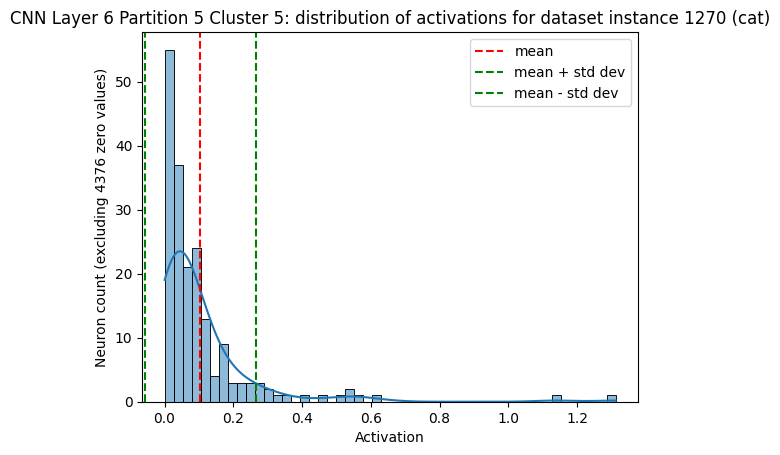

In [369]:
# Get the activations for a given dataset index within the cluster
class_label = dataset[dataset_idx][1]
embeddings_instance = embeddings[:, dataset_idx]
embeddings_instance_cluster = embeddings_instance[clust[:, partition_idx] == cluster_idx].cpu().numpy()

# Keep a count of the zero values and then remove them
zero_count = np.count_nonzero(embeddings_instance_cluster == 0)
embeddings_instance_cluster = embeddings_instance_cluster[embeddings_instance_cluster != 0]

# Start the plot
plt.figure(figsize=(16, 12))
fig, ax = plt.subplots()

# Make the plot while zooming in on the first two standard deviations and marking the mean and std dev
sns.histplot(embeddings_instance_cluster, bins=50, kde=True)
mean = np.mean(embeddings_instance_cluster)
std_dev = np.std(embeddings_instance_cluster)

# Add mean and std dev lines
plt.axvline(mean, color='r', linestyle='--', label='mean')
plt.axvline(mean + std_dev, color='g', linestyle='--', label='mean + std dev')
plt.axvline(mean - std_dev, color='g', linestyle='--', label='mean - std dev')

# ax.set_xlim(mean - 2 * std_dev, mean + 2 * std_dev)
plt.title(f'CNN Layer {layer_idx} Partition {partition_idx} Cluster {cluster_idx}: distribution of activations for dataset instance {dataset_idx} ({class_label})')
plt.ylabel(f'Neuron count (excluding {zero_count} zero values)')
plt.xlabel('Activation')
plt.legend()

We also want to roughly inspect the distribution of subclusters for each audio: this would help us better identify if specific subclusters emerge.

In [338]:
def get_subclusters(cluster_idx, parition_idx, degree=1):
    current_cluster = (clust[:, partition_idx] == cluster_idx)
    subclusters = np.unique(clust[current_cluster, partition_idx - degree])
    return subclusters

In [339]:
# Find which subclusters are present in the current cluster
degree = 1 # how high up the hierarchy we want to look: 1 means directly above
subclusters = get_subclusters(cluster_idx, partition_idx, degree=degree)

# and plot the distribution of the activations for each subcluster
subcluster_activations = {}
for subcluster in subclusters:
    sum_activations = (embeddings_instance[clust[:, partition_idx - degree] == subcluster].cpu().numpy().sum()) 
    n_neurons = np.count_nonzero(clust[:, partition_idx - degree] == subcluster)
    subcluster_activations[subcluster] = sum_activations / n_neurons

df = pd.DataFrame({
    'subcluster': map(str, list(subcluster_activations.keys())),
    'n_neurons': [np.count_nonzero(clust[:, partition_idx - 1] == subcluster) for subcluster in subclusters],
    'norm_activation_sum': list(subcluster_activations.values()),
})

px.bar(df, x='subcluster', y='norm_activation_sum', hover_data=['n_neurons'],
       title=f'CNN Layer {layer_idx} Partition {partition_idx - degree} Subclusters: normalized sum of activations for dataset instance {dataset_idx} ({class_label})')